In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from haloflow import data as D
from haloflow import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis = U.read_best_ndes('msmh.mags_morph_satlum_all_rich_all.maf', device=device)

20 models trained
[18, 4, 0, 14, 11]


In [6]:
y_test, x_test = D.get_subhalos('test', 'mags_morph_satlum_all_rich_all', snapshot=91)

In [9]:
n_sample = 10000

ranks, y_nde = [], []
for i in trange(y_test.shape[0]): 
    y_samp = []
    for qphi in qphis: 
        _samp = qphi.sample((int(n_sample/len(qphis)),),
                           x=torch.tensor(x_test[i], dtype=torch.float32).to(device), 
                           show_progress_bars=False)

        y_samp.append(_samp.detach().cpu().numpy())
    y_nde.append(np.concatenate(np.array(y_samp), axis=0))        

    _ranks = []
    for i_dim in range(y_nde[-1].shape[1]): 
        _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < y_test[i, i_dim]))
    ranks.append(_ranks)

ranks = np.array(ranks)
y_nde = np.array(y_nde)

  0%|          | 0/500 [00:00<?, ?it/s]

[]

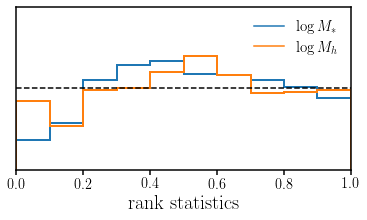

In [10]:
fig = plt.figure(figsize=(6,3))
sub = fig.add_subplot(111)
_ = sub.hist(ranks[:,0], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='C0') 
_ = sub.hist(ranks[:,1], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='C1') 

sub.plot([], [], c='C0', label=r'$\log M_*$')
sub.plot([], [], c='C1', label=r'$\log M_h$')
sub.legend(loc='upper right', fontsize=15)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.set_xlabel('rank statistics', fontsize=20)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 2.)
sub.set_yticks([])

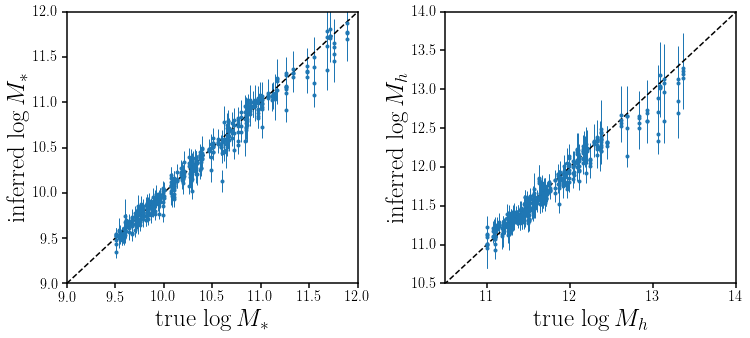

In [14]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
q1, q2, q3 = np.quantile(y_nde[:,:,0], (0.16, 0.5, 0.84), axis=1)
sub.errorbar(y_test[:,0], q2, yerr=[q2-q1, q3-q2], fmt='.C0', lw=1)
sub.plot([9., 15], [9., 15], c='k', ls='--')
sub.set_xlabel(r'true $\log M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel(r'inferred $\log M_*$', fontsize=25)
sub.set_ylim(9., 12.)

sub = fig.add_subplot(122)
q1, q2, q3 = np.quantile(y_nde[:,:,1], (0.16, 0.5, 0.84), axis=1)
sub.errorbar(y_test[:,1], q2, yerr=[q2-q1, q3-q2], fmt='.C0', lw=1)
sub.plot([9., 15], [9., 15], c='k', ls='--')
sub.set_xlabel(r'true $\log M_h$', fontsize=25)
sub.set_xlim(10.5, 14.)
sub.set_ylabel(r'inferred $\log M_h$', fontsize=25)
sub.set_ylim(10.5, 14.)

fig.subplots_adjust(wspace=0.3)